
This is a image recognition project to know if a dog is on the road in front of a car, and avoid the dog!

**Building a detector that can tell when a car sees a dog or normal road**!



In [12]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.array(input)
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size),input] = 1
  
  return output


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  # gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  fig, ax = plt.subplots(1,1)

  img = ax.imshow(my_img, extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)
  
def CNNClassifier(num_epochs=30, layers=5, dropout=0.5):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

In [13]:
# load our data 
data, labels = load_data()

--2022-11-09 10:03:19--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.03s   

2022-11-09 10:03:19 (121 MB/s) - ‘cifar_data’ saved [3689015/3689015]



label: dog


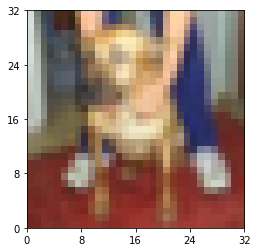

In [14]:
plot_one_image(data, labels, 2) #change this number

label: road


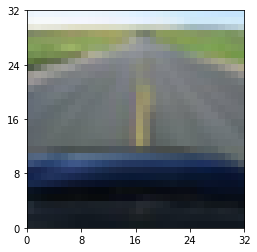

In [15]:
plot_one_image(data, labels, 702) #change this number

In [16]:
print (len(data))

print(Counter(labels))


1200
Counter({'dog': 600, 'road': 600})


label: dog
label: dog
label: dog
label: road
label: road


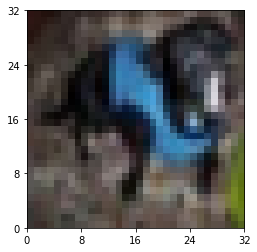

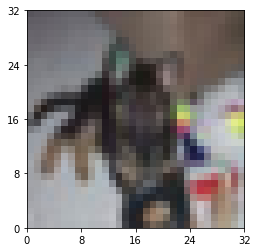

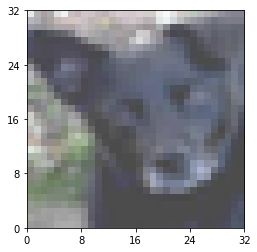

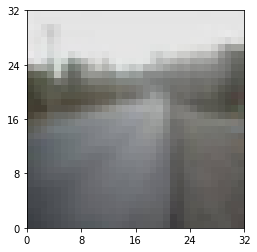

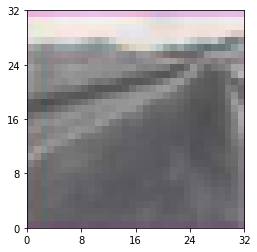

In [17]:
### YOUR CODE HERE
for picture in range(5):
  plot_one_image(data, labels, 200*picture)

### END CODE

In [18]:
print('One image looks like: ')
print(data[0])
print("Length of list: ", len(data[0]))

One image looks like: 
[45 20 19 ... 83 99 31]
Length of list:  3072


In [19]:
img_height = 32 #Change this
img_width = 32 #Change this
color_channels = 3 #Change this

print ("Each image is", img_height, 'x', img_width, 'pixels.')
print ("Each pixel has", color_channels, "channels for red, green, blue.")
print ("This gives a total of", img_height * img_width * color_channels, "intensity values per image.")
print ("Should be", len(data[0]))

Each image is 32 x 32 pixels.
Each pixel has 3 channels for red, green, blue.
This gives a total of 3072 intensity values per image.
Should be 3072


In [20]:
print ('Data shape:', data.shape)
print ('Data:', data)

Data shape: (1200, 3072)
Data: [[ 45  20  19 ...  83  99  31]
 [101 114  35 ... 155 134  91]
 [213 221 221 ... 139  58  47]
 ...
 [126 174 202 ... 124 128 129]
 [191 232 240 ...  74  93  81]
 [237 248 254 ...  45  56  10]]


#A Simple Machine Learner

Building a KNN

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2)
### YOUR CODE HERE
KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)
print(accuracy_score(y_pred,y_test))

### END CODE

0.825


TRUE POSITIVES
label: dog
label: dog
label: dog
label: dog


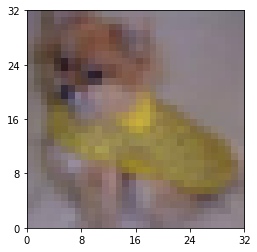

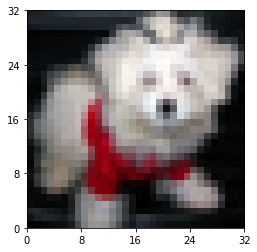

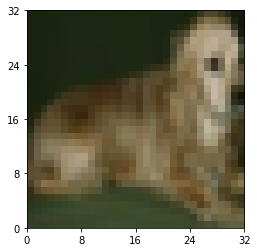

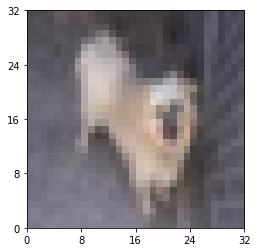

In [22]:
#True Positives (code provided)
tp_count = 0
print ("TRUE POSITIVES")
i = 0
while tp_count < 4 and i < len(X_test):
  prediction = KNN.predict([X_test[i]])[0] 
  if prediction == y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    tp_count += 1
  i += 1

#False Positives
#YOUR CODE HERE

#True Negatives
#YOUR CODE HERE

#False Negatives
#YOUR CODE HERE

#Neural Networks

In [23]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(20,1), random_state=1, max_iter= 10000000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(X_train, y_train)
# Predict what the classes are based on the testing data
predictions = nnet.predict(X_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Set Score:
49.166666666666664


# Convolutional Neural Networks


In [24]:
# convert our data to floats for our CNN
X_train = X_train.astype(float)
X_test = X_test.astype(float)

### YOUR CODE HERE
# Create and train our cnn
cnn = CNNClassifier(num_epochs=30)
cnn.fit(X_train,y_train)
y_pred = cnn.predict(X_test)
# Predict what the classes are based on the testing data

# Print the score on the testing data

print(accuracy_score(y_test,y_pred))
### END CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/30
96/96 - 11s - loss: 1.0366 - accuracy: 0.7167 - 11s/epoch - 111ms/step
Epoch 2/30
96/96 - 1s - loss: 0.2774 - accuracy: 0.8885 - 517ms/epoch - 5ms/step
Epoch 3/30
96/96 - 1s - loss: 0.2224 - accuracy: 0.9073 - 515ms/epoch - 5ms/step
Epoch 4/30
96/96 - 1s - loss: 0.1925 - accuracy: 0.9323 - 532ms/epoch - 6ms/step
Epoch 5/30
96/96 - 1s - loss: 0.1544 - accuracy: 0.9427 - 520ms/epoch - 5ms/step
Epoch 6/30
96/96 - 1s - loss: 0.1626 - accuracy: 0.9344 - 525ms/epoch - 5ms/step
Epoch 7/30
96/96 - 1s - loss: 0.1341 - accuracy: 0.9542 - 526ms/epoch - 5ms/step
Epoch 8/30
96/96 - 1s - loss: 0.1219 - accuracy: 0.9563 - 527ms/epoch - 5ms/step
Epoch 9/30
96/96 - 1s - loss: 0.1215 - accuracy: 0.9594 - 501ms/epoch - 5ms/step
Epoch 10/30
96/96 - 1s - loss: 0.0915 - accuracy: 0.9698 - 510ms/epoch - 5ms/step
Epoch 11/30
96/96 - 1s - loss: 0.1144 - accuracy: 0.9635 - 517ms/epoch - 5ms/step
Epoch 12/30
96/96 - 1s - loss: 0.0965 - accuracy: 0.9635 - 518ms/epoch - 5ms/step
Epoch 13/30
96/96 - 1s -

Epoch 1/30
96/96 - 2s - loss: 0.8638 - accuracy: 0.7344 - val_loss: 0.2233 - val_accuracy: 0.9292 - 2s/epoch - 24ms/step
Epoch 2/30
96/96 - 1s - loss: 0.3224 - accuracy: 0.8719 - val_loss: 0.1800 - val_accuracy: 0.9333 - 597ms/epoch - 6ms/step
Epoch 3/30
96/96 - 1s - loss: 0.2662 - accuracy: 0.8958 - val_loss: 0.1914 - val_accuracy: 0.9167 - 602ms/epoch - 6ms/step
Epoch 4/30
96/96 - 1s - loss: 0.1838 - accuracy: 0.9219 - val_loss: 0.1378 - val_accuracy: 0.9583 - 601ms/epoch - 6ms/step
Epoch 5/30
96/96 - 1s - loss: 0.1973 - accuracy: 0.9333 - val_loss: 0.1476 - val_accuracy: 0.9458 - 572ms/epoch - 6ms/step
Epoch 6/30
96/96 - 1s - loss: 0.1669 - accuracy: 0.9344 - val_loss: 0.1329 - val_accuracy: 0.9542 - 596ms/epoch - 6ms/step
Epoch 7/30
96/96 - 1s - loss: 0.1356 - accuracy: 0.9458 - val_loss: 0.1828 - val_accuracy: 0.9500 - 583ms/epoch - 6ms/step
Epoch 8/30
96/96 - 1s - loss: 0.1462 - accuracy: 0.9500 - val_loss: 0.1460 - val_accuracy: 0.9500 - 601ms/epoch - 6ms/step
Epoch 9/30
96/96 -

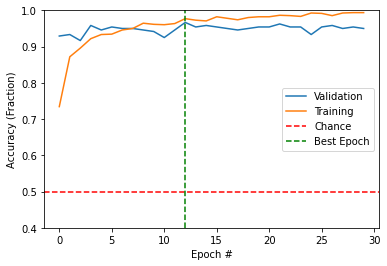

In [26]:
### YOUR CODE HERE
history = cnn.fit(X_train, categorical_to_numpy(y_train), validation_data=(X_test, categorical_to_numpy(y_test)))
plot_acc(history)

### END CODE

# Explainability through Saliency Maps

(3072,)
[205. 209. 221. ... 166. 174. 185.]


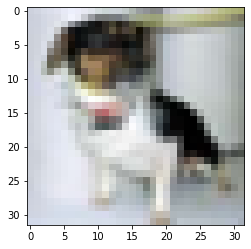

Classification:
1/1 [==============================] - 0s 327ms/step
[0]


In [27]:
image_index = 70 #pick any image you'd like
input_image = X_test[image_index] 
print (input_image.shape) 
print (input_image) #How many numbers are there? What does each represent?

plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

print ('Classification:')
print(cnn.predict(np.array([input_image]))) #Our predict function expects a 2D array.
#0 means dog, 1 means road

In [28]:
#Warning: expect a large output!
for layer_weights in history.model.weights:
  print (layer_weights)

<tf.Variable 'conv2d_8/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
array([[[[-7.88209289e-02, -1.30412310e-01,  1.05641037e-01,
           1.11111738e-01, -5.08915558e-02, -1.00448713e-01,
           1.23418070e-01,  3.63162123e-02,  8.01072270e-02,
           1.39650172e-02,  1.33548409e-01, -7.40051791e-02,
          -8.47084895e-02,  7.26189688e-02, -6.98193684e-02,
          -2.39394587e-02, -1.18768379e-01,  9.16521773e-02,
           5.58594652e-02,  1.96716134e-02,  1.18534837e-03,
          -2.28289124e-02, -8.34970400e-02, -1.29913330e-01,
          -6.76954016e-02, -8.78058523e-02, -1.28681483e-02,
           9.32209864e-02,  1.21027846e-02,  1.17735535e-01,
          -5.28085902e-02, -8.29283223e-02],
         [ 7.06738979e-02, -2.08763722e-02, -2.98267752e-02,
          -3.84453945e-02, -4.29519564e-02,  6.92316890e-02,
          -7.02164471e-02, -3.90424579e-02, -2.99144946e-02,
           2.36896332e-02,  6.47588000e-02,  1.13862291e-01,
           3.93226855e-02,

In [29]:
pred = cnn.predict_proba(np.array([input_image])) #What does each number mean?
print (pred)
dog_prob = pred[0][0] #This is the probability we'll use (if we know dog prob, we know the classification)

print ('Probability of dog:')
print (dog_prob)

1/1 [==============================] - 0s 31ms/step
[[1.0000000e+00 3.2158327e-09]]
Probability of dog:
1.0


In [30]:
saliencies = [] #eventually, will be the same size as input_image

for index, pixel in enumerate(input_image):
  #index counts up from 0, pixel is between 0 and 255
  
  if index%100 == 0: #will track progress - this might take a while
    print (index)
  
  changed_input = input_image.copy() #make sure not to change the original input_image!
  
  #YOUR CODE HERE:
  #In changed_input, change the value of this pixel by some amount.
  #Use the CNN to classify changed_input.
  #Calculate the value of D.
  #Repeat with various-size changes, and calculate saliency as the average D.
  saliency = 0 #Change this!

  saliencies.append(saliency)

print (saliencies)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [31]:
sal_array = np.array(saliencies)
print (sal_array.min(), sal_array.max())
print (sal_array.shape)

0 0
(3072,)


In [32]:
sal_array = np.array(saliencies)
sal_array = sal_array - sal_array.min()
#TODO print min and max

sal_array = sal_array/sal_array.max()
#TODO print min and max


print (sal_array.shape)

(3072,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


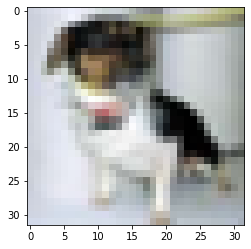

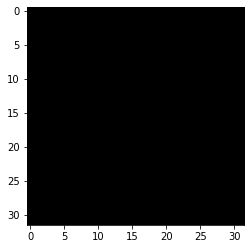

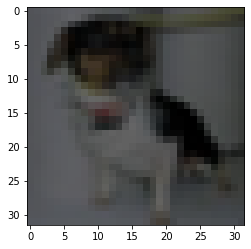

In [33]:
#Plot our original image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

#Plot our saliency map: the brighter, the higher the saliency
plt.imshow(sal_array.reshape(32,32,3))
plt.show()

#Plot our saliency map superimposed on the image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.imshow(sal_array.reshape(32,32,3),alpha=0.6)
plt.show()